##### Deep NMF
**Short Overview**
* To implement Deep NMF, we have utilized the embedding layers.
* Here we tried converting each userId and movieId into its corresponding embedding layer of each of size k.
* user_embedding is nothing but a row vector of W\[i\], similarly our movie_embedding is a row_vector of H\[i\].
* Dot product of these two vectors is our R\[i\]. Thats it! This is what our Matrix factorization does. Now Applying non negative constraint to embedding layer turns out to produce non negative W and H.

**Learning:**
* One beauty about embedding layer is that it is very good at learning relationships like: king-queen = man-woman.
* This property of embedding layer helps us in achieving the goal of collaborative filtering. As the users with almost similar behaviour will turn out to have closely related embeddings.

In [1]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from datetime import datetime

In [2]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, Concatenate, Dot
from tensorflow.keras.layers import Dropout, BatchNormalization, Activation
from tensorflow.keras.regularizers import l2,l1
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.constraints import NonNeg, non_neg

In [3]:
df = pd.read_csv('./data/very_small_rating.csv')

In [4]:
N = df.userId.max() + 1 # number of users
M = df.movie_idx.max() + 1 # number of movies
K=20
reg = 0. # regularization penalty

In [5]:
df = shuffle(df)
cutoff = int(0.8 * len(df))
df_train = df.iloc[:cutoff]
df_test = df.iloc[cutoff:]

In [6]:
# keras model
# shape parameter specifies the input shape of the layer
# Classes from the tf.keras.constraints module allow setting constraints (eg. non-negativity) on model parameters during "training".
u = Input(shape=(1,))
m = Input(shape=(1,)) 
u_embedding = Embedding(N, K,embeddings_regularizer=l2(reg),embeddings_constraint=non_neg())(u) # (N, 1, K)
m_embedding = Embedding(M, K,embeddings_regularizer=l2(reg),embeddings_constraint=non_neg())(m) # (M, 1, K)
x = Dot(axes=2)([u_embedding, m_embedding]) 

In [7]:
x

<KerasTensor: shape=(None, 1, 1) dtype=float32 (created by layer 'dot')>

In [8]:
model = Model(inputs=[u, m], outputs=x)
model.compile(optimizer='adam',loss='mse')

In [9]:
r=model.fit(
    x=[df_train.userId.values, df_train.movie_idx.values],
    y=df_train.rating.values,
    epochs=10, 
    batch_size=100,
    validation_data=(
        [df_test.userId.values, df_test.movie_idx.values],
        df_test.rating.values
    )
)

Epoch 1/10
8298/8298 [==============================] - 29s 3ms/step - loss: 1.9970 - val_loss: 1.0894
Epoch 2/10
8298/8298 [==============================] - 31s 4ms/step - loss: 1.0885 - val_loss: 1.0895
Epoch 3/10
8298/8298 [==============================] - 27s 3ms/step - loss: 1.0885 - val_loss: 1.0901
Epoch 4/10
8298/8298 [==============================] - 27s 3ms/step - loss: 1.0884 - val_loss: 1.0886
Epoch 5/10
8298/8298 [==============================] - 28s 3ms/step - loss: 1.0882 - val_loss: 1.0886
Epoch 6/10
8298/8298 [==============================] - 28s 3ms/step - loss: 1.0882 - val_loss: 1.0894
Epoch 7/10
8298/8298 [==============================] - 27s 3ms/step - loss: 1.0881 - val_loss: 1.0883
Epoch 8/10
8298/8298 [==============================] - 27s 3ms/step - loss: 1.0881 - val_loss: 1.0894
Epoch 9/10
8298/8298 [==============================] - 27s 3ms/step - loss: 1.0881 - val_loss: 1.0885
Epoch 10/10
8298/8298 [==============================] - 27s 3ms/step - l

In [18]:
# print user_embedding layer of model
# len(df_train.userId.unique())
model.layers[2].get_weights()[0].shape

(701, 20)

In [21]:
# In nmf, R=WH, here W is our user_embedding matrix, H is our movie_embedding matrix

W = model.layers[2].get_weights()[0]
H = model.layers[3].get_weights()[0]
print(W.shape, H.shape)

(701, 20) (4001, 20)


In [22]:
metric = pd.DataFrame(data=r.history)
metric



,loss,val_loss
0,1.996960,1.089409
1,1.088472,1.089516
2,1.088451,1.090088
3,1.088392,1.088591
4,1.088231,1.088589
5,1.088237,1.089382
6,1.088139,1.088314
7,1.088069,1.089422
8,1.088079,1.088514
9,1.088027,1.087732


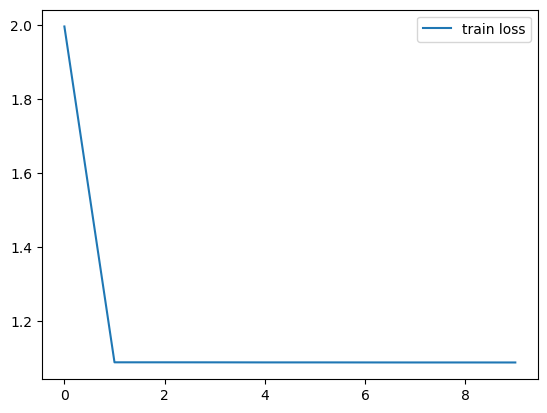

In [23]:
# plot losses
plt.plot(r.history['loss'], label="train loss")
plt.legend()
plt.show()

In [26]:
tempUser = np.array([200]) # user 201 
tempMovie = np.array([55]) # movie 56
model.predict([tempUser, tempMovie])
# the output signifies the rating that user 201 would give to movie 56

1/1 [==============================] - 0s 47ms/step


array([[[3.3129315]]], dtype=float32)

In [27]:
preds = model.predict([df_test.userId.values, df_test.movie_idx.values])

6483/6483 [==============================] - 8s 1ms/step


In [28]:
# calculate the mse
from sklearn.metrics import mean_squared_error
mean_squared_error(df_test.rating, preds.reshape(-1))

1.0788575834668137

#### Now using Neural Network

In [100]:
u = Input(shape=(1,))
m = Input(shape=(1,)) 
u_embedding = Embedding(N, K,embeddings_regularizer=l2(reg),embeddings_constraint=non_neg())(u) # (N, 1, K)
m_embedding = Embedding(M, K,embeddings_regularizer=l2(reg),embeddings_constraint=non_neg())(m) # (N, 1, K)

x = Dot(axes=2)([u_embedding,m_embedding])


In [101]:
x = Flatten()(x) # (N, 1)
x = Dropout(0.2)(x)

In [102]:
x = Dense(400)(x)
x = Activation('relu')(x)
x = Dropout(0.2)(x)

x = Dense(200)(x)
x = Activation('relu')(x)
x = Dropout(0.2)(x)

x = Dense(1,activation='relu')(x)

In [103]:
model = Model(inputs=[u, m], outputs=x)
model.compile(
    loss='mse',
    optimizer='adam',
)

In [104]:
r=model.fit(
    x=[df_train.userId.values, df_train.movie_idx.values],
    y=df_train.rating.values,
    epochs=10, 
    batch_size=50,
    validation_data=(
        [df_test.userId.values, df_test.movie_idx.values],
        df_test.rating.values
    )
)

Epoch 1/10
16596/16596 [==============================] - 80s 5ms/step - loss: 0.9221 - val_loss: 0.7692
Epoch 2/10
16596/16596 [==============================] - 86s 5ms/step - loss: 0.8506 - val_loss: 0.7308
Epoch 3/10
16596/16596 [==============================] - 82s 5ms/step - loss: 0.7973 - val_loss: 0.7221
Epoch 4/10
16596/16596 [==============================] - 84s 5ms/step - loss: 0.7032 - val_loss: 0.6460
Epoch 5/10
16596/16596 [==============================] - 87s 5ms/step - loss: 0.6786 - val_loss: 0.6526
Epoch 6/10
16596/16596 [==============================] - 85s 5ms/step - loss: 0.6640 - val_loss: 0.6342
Epoch 7/10
16596/16596 [==============================] - 82s 5ms/step - loss: 0.6557 - val_loss: 0.6858
Epoch 8/10
16596/16596 [==============================] - 82s 5ms/step - loss: 0.6493 - val_loss: 0.6746
Epoch 9/10
16596/16596 [==============================] - 89s 5ms/step - loss: 0.6436 - val_loss: 0.7035
Epoch 10/10
16596/16596 [==============================

In [105]:
metric = pd.DataFrame(data=r.history)
metric

,loss,val_loss
0,0.922089,0.769241
1,0.850639,0.730814
2,0.797258,0.722114
3,0.703211,0.646027
4,0.678553,0.652640
5,0.664010,0.634154
6,0.655719,0.685817
7,0.649308,0.674570
8,0.643617,0.703470
9,0.639029,0.704342


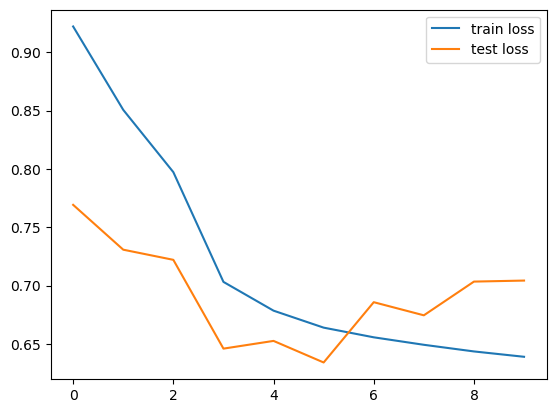

In [106]:
# plot losses
plt.plot(r.history['loss'], label="train loss")
plt.plot(r.history['val_loss'], label="test loss")
plt.legend()
plt.show()

In [108]:
preds = model.predict([df_test.userId.values, df_test.movie_idx.values])

6483/6483 [==============================] - 9s 1ms/step


In [109]:
# calculate the mse
from sklearn.metrics import mean_squared_error
mean_squared_error(df_test.rating, preds.reshape(-1))

0.7043429797001011

In [110]:
tempUser = np.array([100]) # user 101 
tempMovie = np.array([65]) # movie 66
model.predict([tempUser, tempMovie])
# the output signifies the rating that user 101 would give to movie 66

1/1 [==============================] - 0s 89ms/step


array([[2.5352743]], dtype=float32)

#### Neural Collaborative Filtering (A different approach)

* Just found an interesting paper which uses Matrix factorization with Deep neural network implementing some another approach.
* 
* ![''](image.png)
* Here Instead of General Matrix Factorization I tried using Nonnegative matrix factorization
* source: https://arxiv.org/pdf/1708.05031.pdf

In [111]:
u = Input(shape=(1,))
m = Input(shape=(1,)) 


# MLP Embeddings
u_embedding_mlp = Embedding(N, K, name='u-embedding-mlp',embeddings_regularizer=l2(reg))(u)
m_embedding_mlp = Embedding(M , K, name='movie-embedding-mlp',embeddings_regularizer=l2(reg))(m)

# MF Embeddingsx
u_embedding_mf = Embedding(N, K,embeddings_regularizer=l2(reg),embeddings_constraint=non_neg())(u) # (N, 1, K)
m_embedding_mf = Embedding(M, K,embeddings_regularizer=l2(reg),embeddings_constraint=non_neg())(m) # (M, 1, K)

#MLP layers
u_mlp = Flatten()(u_embedding_mlp)
m_mlp = Flatten()(m_embedding_mlp)
conc = Concatenate()([u_mlp, m_mlp])
mlp = Dropout(0.2)(conc)
mlp = Dense(400,activation='relu')(mlp)
mlp = Dropout(0.2)(mlp)
mlp = Dense(200,activation='relu')(mlp)
mlp = Dropout(0.2)(mlp)

# final prediction
mlp_pred = Dense(K,activation='relu')(mlp)
mf_pred = Dot(axes=2)([u_embedding_mf,m_embedding_mf])
mf_pred = Flatten()(mf_pred)
fused_mf_mlp = Concatenate()([mlp_pred,mf_pred])

result = Dense(1)(fused_mf_mlp)

In [112]:
model = Model(inputs=[u, m], outputs=result)
model.compile(optimizer='adam',loss='mse')

In [113]:
r=model.fit(
    x=[df_train.userId.values, df_train.movie_idx.values],
    y=df_train.rating.values,
    epochs=10,
    batch_size=50,
    validation_data=(
        [df_test.userId.values, df_test.movie_idx.values],
        df_test.rating.values,),

)

Epoch 1/10
16596/16596 [==============================] - 134s 8ms/step - loss: 0.7020 - val_loss: 0.6332
Epoch 2/10
16596/16596 [==============================] - 129s 8ms/step - loss: 0.6225 - val_loss: 0.6057
Epoch 3/10
16596/16596 [==============================] - 127s 8ms/step - loss: 0.5944 - val_loss: 0.5844
Epoch 4/10
16596/16596 [==============================] - 126s 8ms/step - loss: 0.5680 - val_loss: 0.5732
Epoch 5/10
16596/16596 [==============================] - 155s 9ms/step - loss: 0.5472 - val_loss: 0.5690
Epoch 6/10
16596/16596 [==============================] - 141s 8ms/step - loss: 0.5318 - val_loss: 0.5631
Epoch 7/10
16596/16596 [==============================] - 133s 8ms/step - loss: 0.5207 - val_loss: 0.5667
Epoch 8/10
16596/16596 [==============================] - 129s 8ms/step - loss: 0.5128 - val_loss: 0.5619
Epoch 9/10
16596/16596 [==============================] - 130s 8ms/step - loss: 0.5056 - val_loss: 0.5618
Epoch 10/10
16596/16596 [=====================

In [114]:
metric = pd.DataFrame(data=r.history)
metric

,loss,val_loss
0,0.701999,0.633180
1,0.622489,0.605733
2,0.594397,0.584378
3,0.567971,0.573159
4,0.547184,0.568963
5,0.531836,0.563125
6,0.520701,0.566706
7,0.512777,0.561860
8,0.505576,0.561764
9,0.499951,0.560933


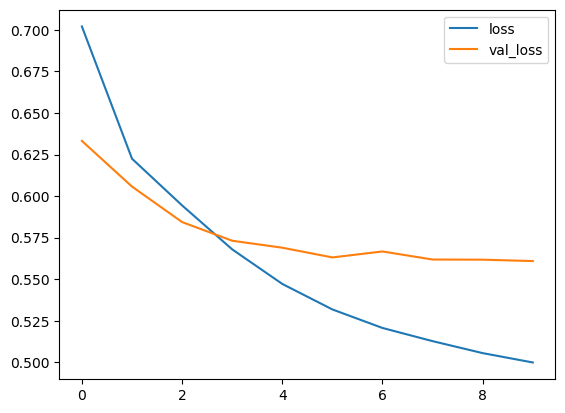

In [115]:
metric.plot()

In [116]:
preds = model.predict([df_test.userId.values, df_test.movie_idx.values])

6483/6483 [==============================] - 15s 2ms/step


In [117]:
# calculate mse
from sklearn.metrics import mean_squared_error
mean_squared_error(df_test.rating, preds.reshape(-1))

0.5609328807160708

#### Conclusion:
* Mean squared errors:
    * linear embedding model of NMF: **1.0788575834668137**
    * NMF with neural network: **0.7043429797001011**
    * NMF with fused Multi Layer Perceptron: **0.5609328807160708**

#### References:
* https://www.researchgate.net/publication/275645705_Matrix_Factorization_Model_in_Collaborative_Filtering_Algorithms_A_Survey
* https://iopscience.iop.org/article/10.1088/1742-6596/1060/1/012001/pdf
* https://arxiv.org/pdf/1708.05031.pdf